# XGBoost classifier of OK states of anesthesia

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)

import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple, List
import json
import os

from collections import Counter

import shap

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    log_loss,
)

## Data loading and visualization

The data is stored within 'box_plot_data' folder. Each state between 0 and 20 + 21 for unwanted data is a dictionnary key given access to a list of the metrics values computed on signal parts labelled as the key. Dictionnaries for each metrics are made at the same time iterating over recordings. As an example this means that the 3rd value of state key 10 in the lists of every metrics dictionnaries are all for the same signal part.

In [15]:
D_data = np.load('box_plot_data/D.npy', allow_pickle=True).item()
transform = True
if transform:
    # convert data for box plots visualization
    prop_delta = [np.log(D_data['D_prop_delta'][i]) for i in range(22)]
    prop_alpha = [np.log(D_data['D_prop_delta'][i]) for i in range(22)]
    prop_beta  = [np.log(D_data['D_prop_beta'][i]) for i in range(22)]
    prop_gamma = [np.log(D_data['D_prop_gamma'][i]) for i in range(22)]

    alpha_delta = [np.log(D_data['D_alpha_delta'][i]) for i in range(22)]
    beta_delta = [np.log(D_data['D_beta_delta'][i]) for i in range(22)]
    gamma_delta = [np.log(D_data['D_gamma_delta'][i]) for i in range(22)]
    beta_alpha = [np.log(D_data['D_beta_alpha'][i]) for i in range(22)]
    gamma_alpha = [np.log(D_data['D_gamma_alpha'][i]) for i in range(22)]
    gamma_beta = [np.log(D_data['D_gamma_alpha'][i]) for i in range(22)]
    hf_lf = [np.log(D_data['D_hf_lf'][i]) for i in range(22)]

    f_50_q = [D_data['D_50_q'][i] for i in range(22)]
    f_75_q = [D_data['D_75_q'][i] for i in range(22)]
    f_85_q = [D_data['D_85_q'][i] for i in range(22)]
    f_95_q = [D_data['D_95_q'][i] for i in range(22)]

    supp = [D_data['D_supp'][i] for i in range(22)]

    line_length = [D_data['D_line_length'][i] for i in range(22)]

    entropy = [D_data['D_entropy'][i] for i in range(22)]
    be = [D_data['D_be'][i] for i in range(22)]

    f_central  = [D_data['D_f_central'][i] for i in range(22)]

else:
    prop_delta = [D_data['D_prop_delta'][i] for i in range(22)]
    prop_alpha = [D_data['D_prop_delta'][i] for i in range(22)]
    prop_beta  = [D_data['D_prop_beta'][i] for i in range(22)]
    prop_gamma = [D_data['D_prop_gamma'][i] for i in range(22)]

    alpha_delta = [D_data['D_alpha_delta'][i] for i in range(22)]
    beta_delta = [D_data['D_beta_delta'][i] for i in range(22)]
    gamma_delta = [D_data['D_gamma_delta'][i] for i in range(22)]
    beta_alpha = [D_data['D_beta_alpha'][i] for i in range(22)]
    gamma_alpha = [D_data['D_gamma_alpha'][i] for i in range(22)]
    gamma_beta = [D_data['D_gamma_alpha'][i] for i in range(22)]
    hf_lf = [D_data['D_hf_lf'][i] for i in range(22)]

    f_50_q = [D_data['D_50_q'][i] for i in range(22)]
    f_75_q = [D_data['D_75_q'][i] for i in range(22)]
    f_85_q = [D_data['D_85_q'][i] for i in range(22)]
    f_95_q = [D_data['D_95_q'][i] for i in range(22)]

    supp = [D_data['D_supp'][i] for i in range(22)]

    line_length = [D_data['D_line_length'][i] for i in range(22)]

    entropy = [D_data['D_entropy'][i] for i in range(22)]
    be = [D_data['D_be'][i] for i in range(22)]

    f_central  = [D_data['D_f_central'][i] for i in range(22)]


Visualize keys in case of columns removals

In [17]:
L_keys = list(D_data.keys())
print(L_keys)
print(L_keys.index('D_supp'))

['D_prop_delta', 'D_prop_alpha', 'D_prop_beta', 'D_prop_gamma', 'D_alpha_delta', 'D_beta_delta', 'D_gamma_delta', 'D_beta_alpha', 'D_gamma_alpha', 'D_gamma_beta', 'D_hf_lf', 'D_50_q', 'D_75_q', 'D_85_q', 'D_95_q', 'D_supp', 'D_line_length', 'D_entropy', 'D_be', 'D_f_central']
15


### Visualize distributions

Text(0.5, 1.0, 'prop_gamma')

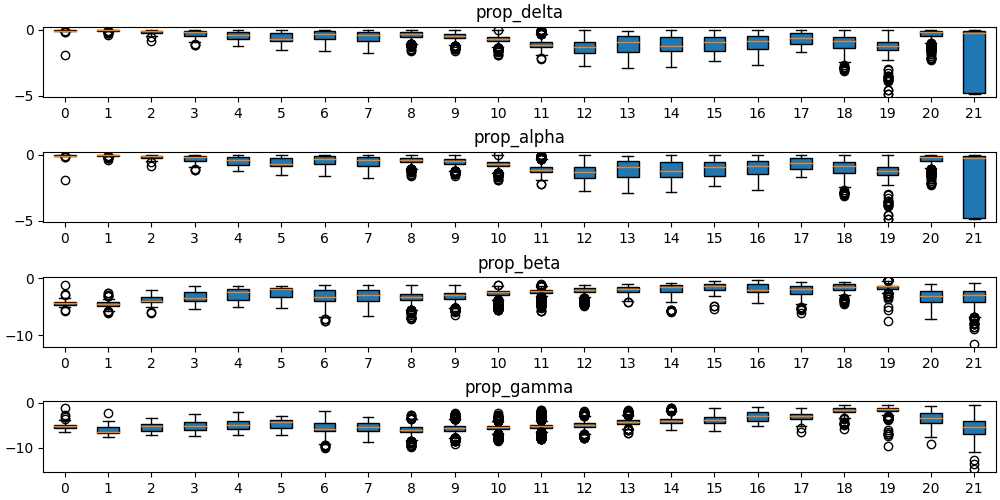

In [16]:
fig, axes = plt.subplots(4, constrained_layout = True)

axes[0].boxplot(prop_delta, positions=range(22), patch_artist=True)
axes[0].set_title('prop_delta')
axes[1].boxplot(prop_alpha, positions=range(22), patch_artist=True)
axes[1].set_title('prop_alpha')
axes[2].boxplot(prop_beta, positions=range(22), patch_artist=True)
axes[2].set_title('prop_beta')
axes[3].boxplot(prop_gamma, positions=range(22), patch_artist=True)
axes[3].set_title('prop_gamma')

Text(0.5, 1.0, 'hf_lf')

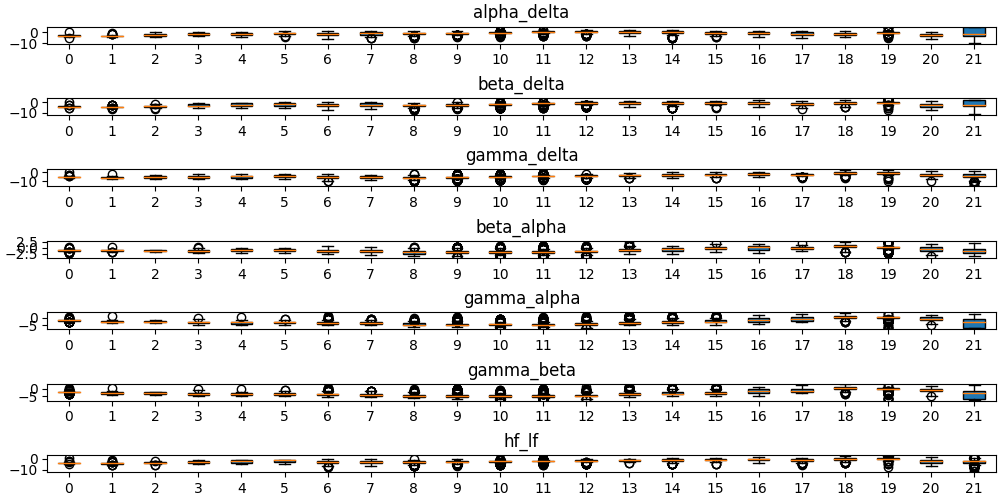

In [18]:
for i in range(4):
    axes[i].set_ylim(0,1)

fig, axes = plt.subplots(7, constrained_layout = True)

axes[0].boxplot(alpha_delta, positions=range(22), patch_artist=True)
axes[0].set_title('alpha_delta')
axes[1].boxplot(beta_delta, positions=range(22), patch_artist=True)
axes[1].set_title('beta_delta')
axes[2].boxplot(gamma_delta, positions=range(22), patch_artist=True)
axes[2].set_title('gamma_delta')
axes[3].boxplot(beta_alpha, positions=range(22), patch_artist=True)
axes[3].set_title('beta_alpha')
axes[4].boxplot(gamma_alpha, positions=range(22), patch_artist=True)
axes[4].set_title('gamma_alpha')
axes[5].boxplot(gamma_beta, positions=range(22), patch_artist=True)
axes[5].set_title('gamma_beta')
axes[6].boxplot(hf_lf, positions=range(22), patch_artist=True)
axes[6].set_title('hf_lf')

Text(0.5, 1.0, 'f_central')

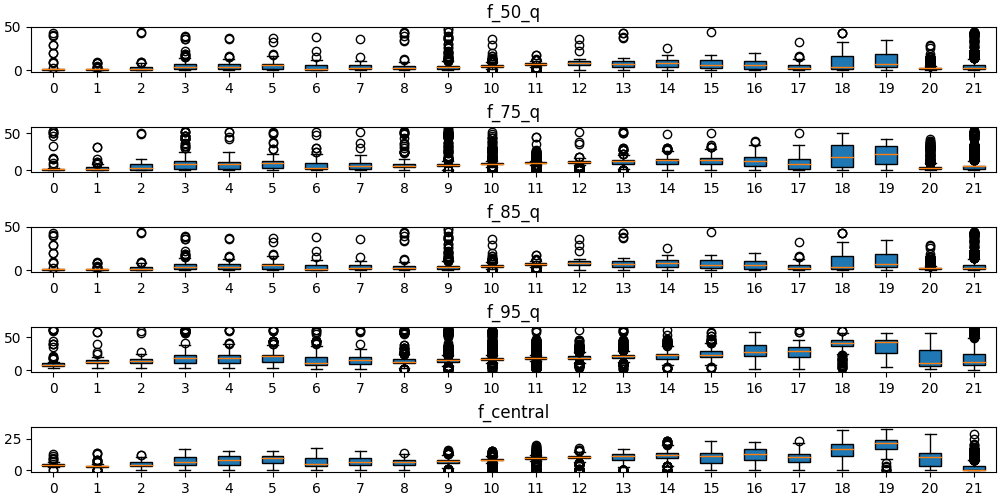

In [6]:
for i in range(7):
    axes[i].set_ylim(0,1)

fig, axes = plt.subplots(5, constrained_layout = True)

axes[0].boxplot(f_50_q, positions=range(22), patch_artist=True)
axes[0].set_title('f_50_q')
axes[1].boxplot(f_75_q, positions=range(22), patch_artist=True)
axes[1].set_title('f_75_q')
axes[2].boxplot(f_50_q, positions=range(22), patch_artist=True)
axes[2].set_title('f_85_q')
axes[3].boxplot(f_95_q, positions=range(22), patch_artist=True)
axes[3].set_title('f_95_q')
axes[4].boxplot(f_central, positions=range(22), patch_artist=True)
axes[4].set_title('f_central')


Text(0.5, 1.0, 'be')

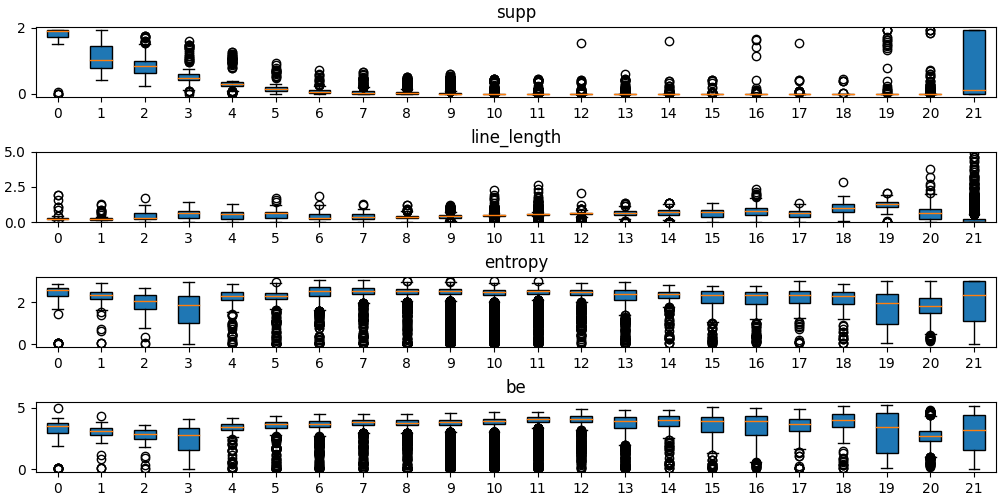

In [7]:
for i in range(4):
    axes[i].set_ylim(0,20)

fig, axes = plt.subplots(4, constrained_layout = True)

axes[0].boxplot(supp, positions=range(22), patch_artist=True)
axes[0].set_title('supp')
axes[1].boxplot(line_length, positions=range(22), patch_artist=True)
axes[1].set_title('line_length')
axes[1].set_ylim(0,5)
axes[2].boxplot(entropy, positions=range(22), patch_artist=True)
axes[2].set_title('entropy')
axes[3].boxplot(be, positions=range(22), patch_artist=True)
axes[3].set_title('be')

## Clean data 
_Looking at the box plots we see a lot of outliers with extremes values that may corrupt data when doing scaler. 
It is best to remove them before continuing further on the classification task._

### Visualize data only in OK range

In [19]:
start, end = 6 , 13  # starting state to end state + 1

Text(0.5, 1.0, 'prop_gamma')

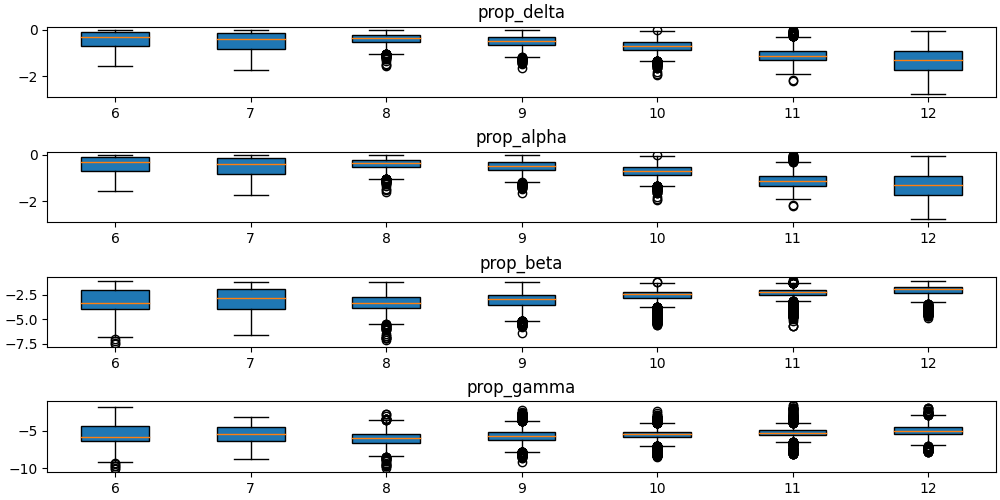

In [27]:
fig, axes = plt.subplots(4, constrained_layout = True)

axes[0].boxplot(prop_delta[start : end], positions=range(start, end), patch_artist=True)
axes[0].set_title('prop_delta')
axes[1].boxplot(prop_alpha[start : end], positions=range(start, end), patch_artist=True)
axes[1].set_title('prop_alpha')
axes[2].boxplot(prop_beta[start : end], positions=range(start, end), patch_artist=True)
axes[2].set_title('prop_beta')
axes[3].boxplot(prop_gamma[start : end], positions=range(start, end), patch_artist=True)
axes[3].set_title('prop_gamma')

Text(0.5, 1.0, 'hf_lf')

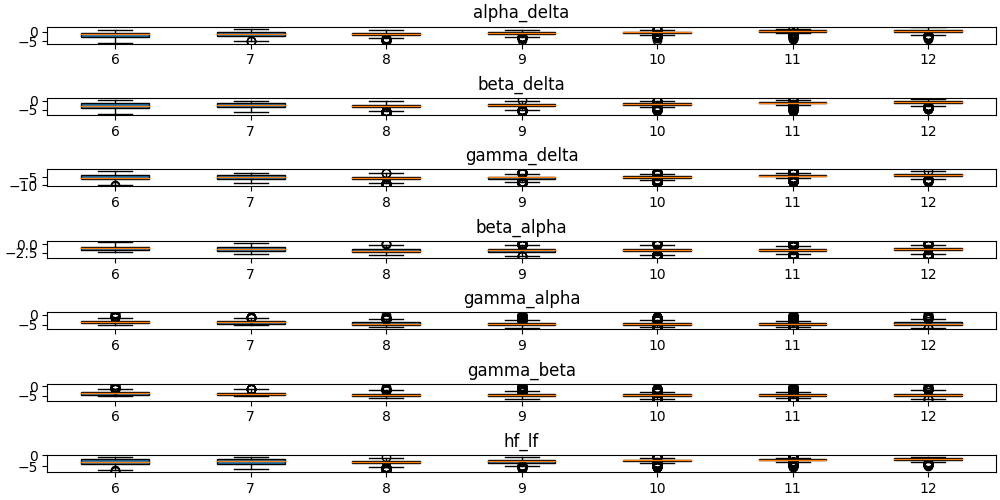

In [26]:
for i in range(4):
    axes[i].set_ylim(0,1)

fig, axes = plt.subplots(7, constrained_layout = True)

axes[0].boxplot(alpha_delta[start : end], positions=range(start, end), patch_artist=True)
axes[0].set_title('alpha_delta')
axes[1].boxplot(beta_delta[start : end], positions=range(start, end), patch_artist=True)
axes[1].set_title('beta_delta')
axes[2].boxplot(gamma_delta[start : end], positions=range(start, end), patch_artist=True)
axes[2].set_title('gamma_delta')
axes[3].boxplot(beta_alpha[start : end], positions=range(start, end), patch_artist=True)
axes[3].set_title('beta_alpha')
axes[4].boxplot(gamma_alpha[start : end], positions=range(start, end), patch_artist=True)
axes[4].set_title('gamma_alpha')
axes[5].boxplot(gamma_beta[start : end], positions=range(start, end), patch_artist=True)
axes[5].set_title('gamma_beta')
axes[6].boxplot(hf_lf[start : end], positions=range(start, end), patch_artist=True)
axes[6].set_title('hf_lf')

Text(0.5, 1.0, 'f_central')

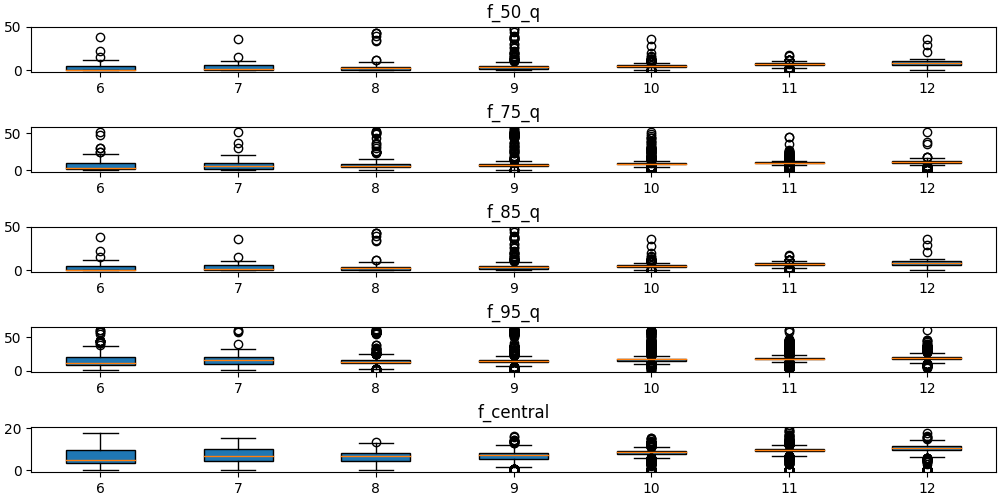

In [22]:
for i in range(7):
    axes[i].set_ylim(0,1)

fig, axes = plt.subplots(5, constrained_layout = True)

axes[0].boxplot(f_50_q[start : end], positions=range(start, end), patch_artist=True)
axes[0].set_title('f_50_q')
axes[1].boxplot(f_75_q[start : end], positions=range(start, end), patch_artist=True)
axes[1].set_title('f_75_q')
axes[2].boxplot(f_50_q[start : end], positions=range(start, end), patch_artist=True)
axes[2].set_title('f_85_q')
axes[3].boxplot(f_95_q[start : end], positions=range(start, end), patch_artist=True)
axes[3].set_title('f_95_q')
axes[4].boxplot(f_central[start : end], positions=range(start, end), patch_artist=True)
axes[4].set_title('f_central')

Text(0.5, 1.0, 'be')

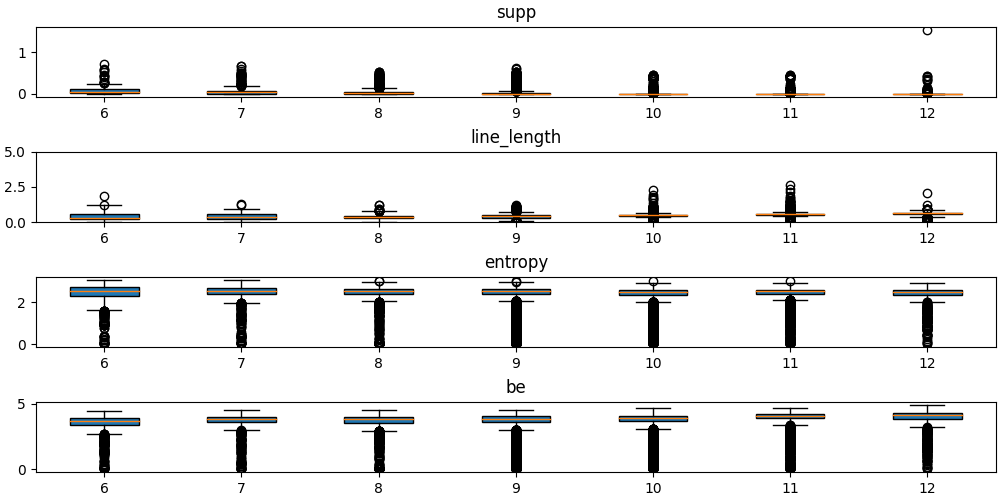

In [23]:
for i in range(4):
    axes[i].set_ylim(0,20)

fig, axes = plt.subplots(4, constrained_layout = True)

axes[0].boxplot(supp[start : end], positions=range(start, end), patch_artist=True)
axes[0].set_title('supp')
axes[1].boxplot(line_length[start : end], positions=range(start, end), patch_artist=True)
axes[1].set_title('line_length')
axes[1].set_ylim(0,5)
axes[2].boxplot(entropy[start : end], positions=range(start, end), patch_artist=True)
axes[2].set_title('entropy')
axes[3].boxplot(be[start : end], positions=range(start, end), patch_artist=True)
axes[3].set_title('be')

### Format data into sample for the classifier
XGBoost can work with different datatype entries. Including their own type. It accepts np.ndarray which is the type chosen here. 
For a classification task, the format is as follow:
- X: (n_samples, n_features)
- y: (n_samples,)

For instance if n_samples = 5 and n_features = 3:

X = [[f01, f02, f03],
     [f11, f12, f13],
     [f21, f22, f23],
     [f31, f32, f33],
     [f41, f42, f43]]

y = [c0, c1, c2, c3, c4]

_Currently the data is stored in a dictionnary where each key is a metric name. The name of the metric gives access to another dictionnary where each key is an integer representing the stae. The integer give access to a list of the value of this particular metrics for this particular state._

In [24]:
def format_data(D, states_range = None):

    keys = list(D.keys()) # convert to list to assess the ken of len(D[keys[0]][i]), otherwise error with keys[0]
    X = []
    y = []
    if states_range == None:
        for i in range(22):
            N_samples_for_current_state = len(D[keys[0]][i])
            print(f'Number of samples in state {i}: {N_samples_for_current_state}')
            for j in range(N_samples_for_current_state):
                L = [] # line vector that will contain all features for this sample positionned at the jth element of state i
                y.append(i)
                for key in keys:
                    L.append(D[key][i][j])
                X.append(L)
    
    elif type(states_range[0]) == int:
        for i in range(states_range[0], states_range[1]): # first state should be lower than second
            N_samples_for_current_state = len(D[keys[0]][i])
            print(f'Number of samples in state {i}: {N_samples_for_current_state}')
            for j in range(N_samples_for_current_state):
                L = [] # line vector that will contain all features for this sample positionned at the jth element of state i
                y.append(i - states_range[0])
                for key in keys:
                    L.append(D[key][i][j])
                X.append(L)        
    
    return np.array(X), np.array(y)

In [25]:
X_6_12, y_6_12 = format_data(D_data, states_range = [6, 13])
print(f'X shape is: {np.shape(X_6_12)}')
print(f'y shape is: {np.shape(y_6_12)}')

Number of samples in state 6: 759
Number of samples in state 7: 1475
Number of samples in state 8: 1820
Number of samples in state 9: 5912
Number of samples in state 10: 8929
Number of samples in state 11: 5088
Number of samples in state 12: 1080
X shape is: (25063, 20)
y shape is: (25063,)


## Train classifier

_Config is used to parametrized all the training of the classifiers_

In [ ]:
@dataclass
class Config:
    # Data
    i_to_drop = [15] # can be None
    shuffle: bool = True # to shuffle dataset before applying any routine
    # Split
    test_size: float = 0.20
    val_size_within_train: float = 0.20  # fraction of trainval used as validation
    seed: int = 42
    # Model
    model_type: str = "lgbm"  # "lgbm" or "xgb"
    use_scaling: bool = True  # recommended for EEG metrics 
    #NOTE: see here if scaling using log must be applied or not
    # Training
    n_estimators: int = 2000
    learning_rate: float = 0.05
    early_stopping_rounds: int = 50
    # CV
    do_cross_val: bool = True
    n_splits_cv: int = 5
    # Output
    out_dir: str = "EEG_classification_" + model_type

cfg = Config()

## Functions

### Separate dataset into train (train+validation) and test sets.

Since we consider each sample IID (we do not consider time dependency here from neigbours). We can use a stratify routine directly. This means we do not account for:

- adjacent windows from the same recording,

- per-subject correlations,

- time ordering

In [ ]:
def get_train_val_test(cfg, D, X, y):

    # give feature name to columns for easy visualisation
    features_names = list(D.keys())
    
    # remove if necessary the unwanted columns of X
    if cfg.i_to_drop != None:
        i = list(range(len(features_names)))
        common = set(i) & set(cfg.i_to_drop)
        i_to_keep = [x for x in i if x not in common]

        X = X[:, i_to_keep]
        # display removed features
        print('removed feature(s):', [features_names[index] for index in cfg.i_to_drop])
        features_names = [features_names[index] for index in i_to_keep]

    if cfg.shuffle:
        # NOTE: shuffle dataset as it is currently ordered   # may not be necessary
        X, y = shuffle(X, y, random_state=cfg.seed)

    # separate X into {train+val} and test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y,
        test_size=cfg.test_size,
        random_state=cfg.seed,
        stratify=y
    )

    # separate {train+val} into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=cfg.val_size_within_train,          
        random_state=cfg.seed,
        stratify=y_trainval
    )

    return X_trainval, y_trainval, X_train, X_val, X_test, y_train, y_val, y_test, features_names

### Models


In [ ]:
def build_model(cfg: Config, n_classes: int):
    if cfg.model_type.lower() == "lgbm":
        import lightgbm as lgb
        model = lgb.LGBMClassifier(
            objective="multiclass",
            num_class=n_classes,
            n_estimators=cfg.n_estimators,
            learning_rate=cfg.learning_rate,
            subsample=0.8,
            colsample_bytree=0.8,
            num_leaves=31,
            random_state=cfg.seed,
            class_weight="balanced",
        )
        return model

    elif cfg.model_type.lower() == "xgb":
        from xgboost import XGBClassifier
        model = XGBClassifier(
            objective="multi:softprob",
            num_class=n_classes,
            n_estimators=cfg.n_estimators,
            learning_rate=cfg.learning_rate,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=cfg.seed,
            eval_metric="mlogloss",
            tree_method="hist",
        )
        return model

    else:
        raise ValueError("cfg.model_type must be 'lgbm' or 'xgb'")

### Create pipeline 

In [ ]:
def build_pipeline(cfg: Config, model) -> Pipeline:
    steps = []
    if cfg.use_scaling:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", model))
    return Pipeline(steps)

### Create Cross Validation routine

In [ ]:
def cross_validate_stratified(
    cfg: Config,
    X: np.ndarray,
    y: np.ndarray,
    n_classes: int
) -> Dict[str, Any]:
    """
    CV scoring only. (No early stopping curves here by default.)
    If you want fold-by-fold training curves, you can extend this loop similarly
    to the final training function below.
    """
    cv = StratifiedKFold(n_splits=cfg.n_splits_cv, shuffle=True, random_state=cfg.seed)
    fold_scores = []

    for fold, (tr, va) in enumerate(cv.split(X, y), 1):
        X_tr, X_va = X[tr], X[va]
        y_tr, y_va = y[tr], y[va]

        model = build_model(cfg, n_classes=n_classes)
        pipe = build_pipeline(cfg, model)

        # Fit without early stopping (simpler + consistent across wrappers)
        pipe.fit(X_tr, y_tr)

        y_pred = pipe.predict(X_va)
        score = balanced_accuracy_score(y_va, y_pred)
        fold_scores.append(score)

    out = {
        "cv_balanced_accuracy_mean": float(np.mean(fold_scores)),
        "cv_balanced_accuracy_std": float(np.std(fold_scores)),
        "cv_balanced_accuracy_folds": [float(s) for s in fold_scores],
    }
    return out

In [ ]:
# # or # NOTE: see what interest their is in using one or the other
# from sklearn.model_selection import StratifiedShuffleSplit

# cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

### Utils

In [ ]:
def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

### Visualise metrics

In [ ]:
def plot_training_curves(evals_result: Dict[str, Any], out_path: str) -> None:
    """
    Plots metric curves for libraries that provide evals_result-like dict.
    Handles common shapes for XGBoost and LightGBM sklearn wrappers.
    """
    if not evals_result:
        return

    plt.figure()
    # XGBoost usually: {'validation_0': {'mlogloss': [..]}, 'validation_1': {...}}
    # LightGBM may produce similar via model.evals_result_.
    for dataset_name, metrics in evals_result.items():
        for metric_name, values in metrics.items():
            plt.plot(values, label=f"{dataset_name}/{metric_name}")

    plt.xlabel("Iteration")
    plt.ylabel("Metric")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

def plot_feature_importance(model_pipeline: Pipeline, feature_names: List[str], out_path: str, top_k: int = 25) -> None:
    """
    Plots feature importance if available.
    Works for LGBMClassifier and XGBClassifier through pipeline.
    """
    clf = model_pipeline.named_steps["clf"]
    if not hasattr(clf, "feature_importances_"):
        return

    importances = clf.feature_importances_
    if importances is None or len(importances) != len(feature_names):
        return

    s = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(top_k)
    plt.figure()
    s.iloc[::-1].plot(kind="barh")  # horizontal bar chart
    plt.xlabel("Importance")
    plt.title("Top feature importances")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

def multiclass_roc_auc(y_true: np.ndarray, y_proba: np.ndarray) -> Optional[float]:
    try:
        return roc_auc_score(y_true, y_proba, multi_class="ovr")
    except Exception:
        return None
    

def shap_global_explanations(
    pipe: Pipeline,
    X_background: np.ndarray,
    X_explain: np.ndarray,
    feature_names: List[str],
    out_dir: str,
    max_explain: int = 2000,
    background_size: int = 512,
) -> None:
    """
    Creates SHAP plots for a tree model inside a sklearn Pipeline.
    Works best for XGBoost / LightGBM.
    Saves:
      - shap_summary_bar.png
      - shap_summary_beeswarm.png

    Notes:
    - For speed, we subsample both background and explain sets.
    - For multiclass, SHAP returns a list (one array per class) depending on SHAP version.
      We aggregate to a global importance for the bar plot if needed.
    """

    ensure_dir(out_dir)

    # Subsample for performance
    rng = np.random.default_rng(42)

    def subsample(X, n):
        if X.shape[0] <= n:
            return X
        idx = rng.choice(X.shape[0], size=n, replace=False)
        return X[idx]

    X_bg = subsample(X_background, background_size)
    X_ex = subsample(X_explain, max_explain)

    # Apply scaler if present
    if "scaler" in pipe.named_steps:
        scaler = pipe.named_steps["scaler"]
        X_bg = scaler.transform(X_bg)
        X_ex = scaler.transform(X_ex)

    model = pipe.named_steps["clf"]

    # TreeExplainer is the right explainer for XGB/LGBM
    explainer = shap.TreeExplainer(model, data=X_bg)
    shap_values = explainer.shap_values(X_ex)

    # ----- Plot 1: Global importance bar -----
    # shap_values can be:
    # - (n_samples, n_features) for binary/regression
    # - list of (n_samples, n_features) per class for multiclass
    if isinstance(shap_values, list):
        # Aggregate across classes: mean(|shap|) over samples then sum/mean over classes
        sv = np.stack([np.abs(sv_c).mean(axis=0) for sv_c in shap_values], axis=0)  # (n_classes, n_features)
        global_importance = sv.mean(axis=0)  # (n_features,)
        order = np.argsort(global_importance)[::-1]
        top = order[: min(30, len(feature_names))]

        plt.figure()
        plt.barh([feature_names[i] for i in top][::-1], global_importance[top][::-1])
        plt.xlabel("mean(|SHAP value|) across classes")
        plt.title("Global feature importance (SHAP)")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "shap_summary_bar.png"), dpi=150)
        plt.close()

        # Beeswarm: pick one class (e.g. class 0) OR average shap values
        # Here: show beeswarm for class 0 for directionality
        try:
            shap.summary_plot(
                shap_values[0], X_ex,
                feature_names=feature_names,
                show=False
            )
            plt.tight_layout()
            plt.savefig(os.path.join(out_dir, "shap_summary_beeswarm.png"), dpi=150)
            plt.close()
        except Exception:
            pass

    else:
        # Standard SHAP summary plots
        shap.summary_plot(shap_values, X_ex, feature_names=feature_names, plot_type="bar", show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "shap_summary_bar.png"), dpi=150)
        plt.close()

        shap.summary_plot(shap_values, X_ex, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "shap_summary_beeswarm.png"), dpi=150)
        plt.close()

### Evaluate Model

In [ ]:
def evaluate(
    model_pipeline: Pipeline,
    X_test: np.ndarray,
    y_test: np.ndarray,
    class_names: List[str],
    out_dir: str
) -> Dict[str, Any]:
    y_pred = model_pipeline.predict(X_test)
    y_proba = None
    if hasattr(model_pipeline, "predict_proba"):
        y_proba = model_pipeline.predict_proba(X_test)

    results = {
        "balanced_accuracy": float(balanced_accuracy_score(y_test, y_pred)),
        "macro_f1": float(f1_score(y_test, y_pred, average="macro")),
    }

    # Log loss if probabilities exist
    if y_proba is not None:
        try:
            results["log_loss"] = float(log_loss(y_test, y_proba))
        except Exception:
            pass

        auc = multiclass_roc_auc(y_test, y_proba)
        if auc is not None:
            results["roc_auc_ovr"] = float(auc)

    # Report
    report = classification_report(y_test, y_pred, target_names=class_names, digits=4)
    with open(os.path.join(out_dir, "classification_report.txt"), "w", encoding="utf-8") as f:
        f.write(report)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(values_format="d")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "confusion_matrix.png"), dpi=150)
    plt.close()

    # Save metrics
    with open(os.path.join(out_dir, "metrics.json"), "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2)

    return results

### Final training

In [ ]:
def fit_with_early_stopping(
    cfg: Config,
    pipe: Pipeline,
    X_train: np.ndarray, y_train: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray
) -> Tuple[Pipeline, Dict[str, Any]]:
    """
    Fits the pipeline with early stopping for XGB/LGBM.
    Because early stopping args differ slightly, we handle both cases.
    Returns (fitted_pipe, evals_result_dict)
    """
    clf = pipe.named_steps["clf"]
    evals_result = {}

    # If scaling is enabled, we must transform train/val for the eval_set manually
    # because the sklearn wrappers expect raw arrays for eval_set (not a Pipeline).
    if "scaler" in pipe.named_steps:
        scaler = pipe.named_steps["scaler"]
        X_train_s = scaler.fit_transform(X_train)
        X_val_s = scaler.transform(X_val)

        if cfg.model_type.lower() == "lgbm":
            clf.fit(
                X_train_s, y_train,
                eval_set=[(X_train_s, y_train), (X_val_s, y_val)],
                eval_metric="multi_logloss",
                callbacks=[],
            )
            # Rebuild pipe with fitted scaler + fitted clf
            pipe.named_steps["clf"] = clf
            evals_result = getattr(clf, "evals_result_", {}) or {}

        else:  # xgb
            clf.fit(
                X_train_s, y_train,
                eval_set=[(X_train_s, y_train), (X_val_s, y_val)],
                verbose=False,
            )
            evals_result = clf.evals_result()

        # Early stopping:
        # Newer versions handle early_stopping_rounds in fit; older may use callbacks.
        # We'll attempt to apply it in a compatible way:
        try:
            if cfg.model_type.lower() == "lgbm":
                import lightgbm as lgb
                clf.fit(
                    X_train_s, y_train,
                    eval_set=[(X_val_s, y_val)],
                    eval_metric="multi_logloss",
                    callbacks=[lgb.early_stopping(cfg.early_stopping_rounds, verbose=False)],
                )
                evals_result = getattr(clf, "evals_result_", {}) or {}
            else:
                clf.fit(
                    X_train_s, y_train,
                    eval_set=[(X_val_s, y_val)],
                    verbose=False,
                    early_stopping_rounds=cfg.early_stopping_rounds,
                )
                evals_result = clf.evals_result()
        except TypeError:
            # If the wrapper doesn't accept early_stopping_rounds/callbacks, skip it.
            pass

        return pipe, evals_result

    else:
        # No scaling: direct
        try:
            if cfg.model_type.lower() == "lgbm":
                import lightgbm as lgb
                clf.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric="multi_logloss",
                    callbacks=[lgb.early_stopping(cfg.early_stopping_rounds, verbose=False)],
                )
                evals_result = getattr(clf, "evals_result_", {}) or {}
            else:
                clf.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False,
                    early_stopping_rounds=cfg.early_stopping_rounds,
                )
                evals_result = clf.evals_result()
        except TypeError:
            clf.fit(X_train, y_train)
            evals_result = getattr(clf, "evals_result_", {}) or {}

        return pipe, evals_result

## Train data

### Get training, validation and test sets

In [ ]:
X_trainval, y_trainval, X_train, X_val, X_test, y_train, y_val, y_test, feature_names = get_train_val_test(cfg, D_data, X_6_12, y_6_12)
classes = Counter(y_6_12)
n_classes = len(classes.keys())
class_names = [str(c) for c in range(n_classes)]
print('Classes repartition:', classes)
print('Number of classes:', n_classes)

removed feature(s): ['D_supp']
Classes repartition: Counter({4: 8929, 3: 5912, 5: 5088, 2: 1820, 1: 1475, 6: 1080, 0: 759})
Number of classes: 7


### Run cross-validation for evaluation of the model

In [ ]:
cv_results = {}
if cfg.do_cross_val:
    ensure_dir(cfg.out_dir)
    cv_results = cross_validate_stratified(cfg, X_trainval, y_trainval, n_classes=n_classes)
    with open(os.path.join(cfg.out_dir, "cv_results.json"), "w", encoding="utf-8") as f:
        json.dump(cv_results, f, indent=2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4102
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4109
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4103
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4104
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4104
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Build model + pipeline
model = build_model(cfg, n_classes=n_classes)
pipe = build_pipeline(cfg, model)

# Fit final with early stopping on validation
pipe, evals_result = fit_with_early_stopping(cfg, pipe, X_train, y_train, X_val, y_val)

# Training curves
if evals_result:
    plot_training_curves(evals_result, os.path.join(cfg.out_dir, "training_curves.png"))
    with open(os.path.join(cfg.out_dir, "evals_result.json"), "w", encoding="utf-8") as f:
        json.dump(evals_result, f, indent=2)

# Evaluate on test
metrics = evaluate(pipe, X_test, y_test, class_names, cfg.out_dir)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Features importance

In [ ]:
# Feature importance
plot_feature_importance(pipe, feature_names, os.path.join(cfg.out_dir, "feature_importance.png"))

In [ ]:
try:
    shap_global_explanations(
        pipe=pipe,
        X_background=X_train,     # background distribution
        X_explain=X_test,         # what to explain
        feature_names=feature_names,
        out_dir=cfg.out_dir
    )
    print("Saved SHAP plots.")
except Exception as e:
    print("SHAP skipped:", repr(e))

100%|===================| 13995/14000 [27:15<00:00]        C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Saved SHAP plots.


### Scale data 

_The different metrics may have some different magnitude orders. To avoid training issues dues to uneven values we scale the data._

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

### XGBoost classifier

In [ ]:
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_validate
import xgboost as xgb

In [ ]:
# NOTE: shuffle dataset as it is currently ordered
X_6_12, y_6_12 = shuffle(X_6_12, y_6_12, random_state=0)
print(np.shape(X_6_12))

(25063, 20)


Visualisation

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.array(X_6_12))

# Plot t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_6_12, cmap='viridis')
plt.title('t-SNE Visualization of Iris Dataset')
plt.colorbar(scatter, label='Species')
plt.show()

KeyboardInterrupt: 

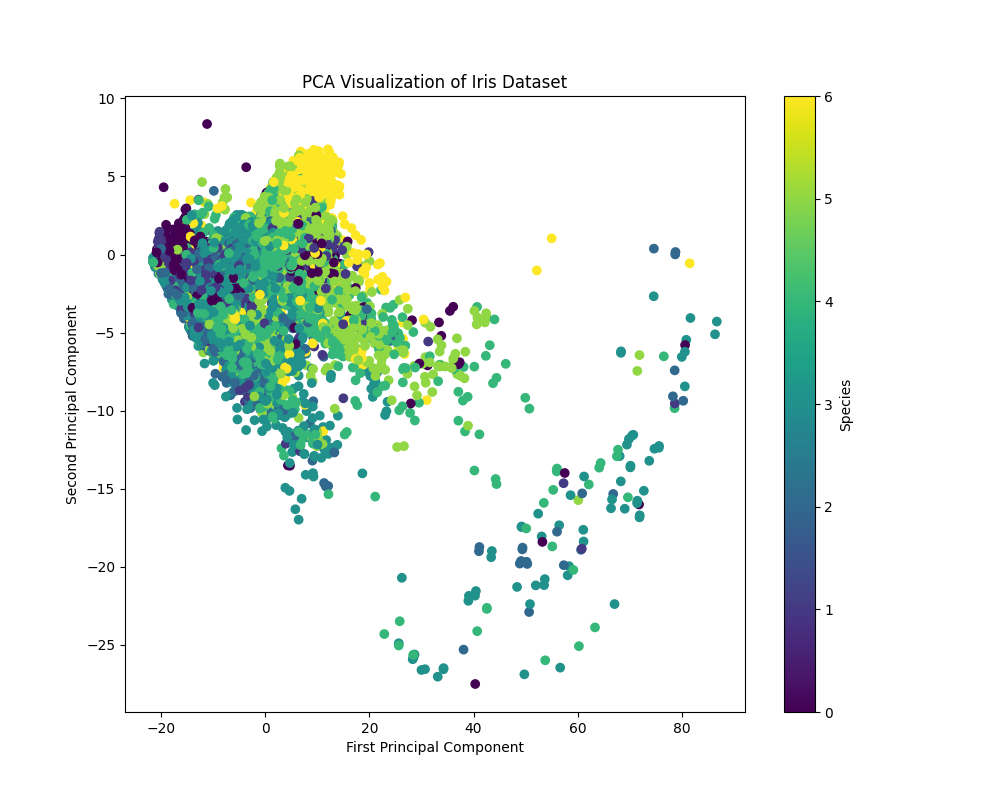

Explained variance ratio: [0.79920957 0.1025253 ]


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_6_12)

# Plot PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_6_12, cmap='viridis')
plt.title('PCA Visualization of Iris Dataset')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Species')
plt.show()

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_6_12, y_6_12, stratify=y_6_12, random_state=94)

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:1.59039
[1]	validation_0-mlogloss:1.39530
[2]	validation_0-mlogloss:1.26093
[3]	validation_0-mlogloss:1.16787
[4]	validation_0-mlogloss:1.09621
[5]	validation_0-mlogloss:1.03617
[6]	validation_0-mlogloss:0.99229
[7]	validation_0-mlogloss:0.95651
[8]	validation_0-mlogloss:0.92747
[9]	validation_0-mlogloss:0.90466
[10]	validation_0-mlogloss:0.88426
[11]	validation_0-mlogloss:0.86790
[12]	validation_0-mlogloss:0.85566
[13]	validation_0-mlogloss:0.84052
[14]	validation_0-mlogloss:0.83060
[15]	validation_0-mlogloss:0.82104
[16]	validation_0-mlogloss:0.81159
[17]	validation_0-mlogloss:0.80387
[18]	validation_0-mlogloss:0.79646
[19]	validation_0-mlogloss:0.79072
[20]	validation_0-mlogloss:0.78428
[21]	validation_0-mlogloss:0.77766
[22]	validation_0-mlogloss:0.77305
[23]	validation_0-mlogloss:0.76820
[24]	validation_0-mlogloss:0.76145
[25]	validation_0-mlogloss:0.75718
[26]	validation_0-mlogloss:0.75466
[27]	validation_0-mlogloss:0.75130
[28]	validation_0-mlogloss:0.7

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.45%


Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_6_12_new = scaler.fit_transform(X_6_12, y_6_12)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_6_12_new, y_6_12, stratify=y_6_12, random_state=94)

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:1.59039
[1]	validation_0-mlogloss:1.39530
[2]	validation_0-mlogloss:1.26093
[3]	validation_0-mlogloss:1.16787
[4]	validation_0-mlogloss:1.09621
[5]	validation_0-mlogloss:1.03617
[6]	validation_0-mlogloss:0.99229
[7]	validation_0-mlogloss:0.95651
[8]	validation_0-mlogloss:0.92747
[9]	validation_0-mlogloss:0.90466
[10]	validation_0-mlogloss:0.88426
[11]	validation_0-mlogloss:0.86790
[12]	validation_0-mlogloss:0.85566
[13]	validation_0-mlogloss:0.84052
[14]	validation_0-mlogloss:0.83060
[15]	validation_0-mlogloss:0.82104
[16]	validation_0-mlogloss:0.81159
[17]	validation_0-mlogloss:0.80387
[18]	validation_0-mlogloss:0.79646
[19]	validation_0-mlogloss:0.79072
[20]	validation_0-mlogloss:0.78428
[21]	validation_0-mlogloss:0.77766
[22]	validation_0-mlogloss:0.77305
[23]	validation_0-mlogloss:0.76820
[24]	validation_0-mlogloss:0.76145
[25]	validation_0-mlogloss:0.75718
[26]	validation_0-mlogloss:0.75466
[27]	validation_0-mlogloss:0.75130
[28]	validation_0-mlogloss:0.7

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.75%


In [ ]:
print(clf.feature_importances_)

[0.03652183 0.07298073 0.05205084 0.03359969 0.10711517 0.06108783
 0.04147763 0.05247194 0.03868655 0.05046906 0.02517308 0.08869404
 0.07013568 0.04102808 0.03947984 0.06222314 0.05309885 0.01796483
 0.01961934 0.03612182]


In [ ]:
# def fit_and_score(estimator, X_train, X_test, y_train, y_test):
#     """Fit the estimator on the train set and score it on both sets"""
#     estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

#     train_score = estimator.score(X_train, y_train)
#     test_score = estimator.score(X_test, y_test)

#     return estimator, train_score, test_score


# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=94)

# clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=3)

# results = {}

# for train, test in cv.split(X_6_12, y_6_12):
#     print(train)
#     X_train = X_6_12[train]
#     X_test = X_6_12[test]
#     y_train = y_6_12[train]
#     y_test = y_6_12[test]
#     est, train_score, test_score = fit_and_score(
#         clone(clf), X_train, X_test, y_train, y_test
#     )
#     results[est] = (train_score, test_score)

In [ ]:
from collections import Counter

print(Counter(y_6_12))

Counter({4: 8929, 3: 5912, 5: 5088, 2: 1820, 1: 1475, 6: 1080, 0: 759})


In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_6_12_new, y_6_12)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({2: 8929, 1: 8929, 3: 8929, 4: 8929, 5: 8929, 6: 8929, 0: 8929})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, random_state=94)

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:1.57762
[1]	validation_0-mlogloss:1.36772
[2]	validation_0-mlogloss:1.23135
[3]	validation_0-mlogloss:1.12245
[4]	validation_0-mlogloss:1.04211
[5]	validation_0-mlogloss:0.97924
[6]	validation_0-mlogloss:0.92757
[7]	validation_0-mlogloss:0.88424
[8]	validation_0-mlogloss:0.84942
[9]	validation_0-mlogloss:0.82126
[10]	validation_0-mlogloss:0.79703
[11]	validation_0-mlogloss:0.77308
[12]	validation_0-mlogloss:0.75327
[13]	validation_0-mlogloss:0.73460
[14]	validation_0-mlogloss:0.71859
[15]	validation_0-mlogloss:0.70153
[16]	validation_0-mlogloss:0.68756
[17]	validation_0-mlogloss:0.67236
[18]	validation_0-mlogloss:0.65697
[19]	validation_0-mlogloss:0.64267
[20]	validation_0-mlogloss:0.63460
[21]	validation_0-mlogloss:0.62081
[22]	validation_0-mlogloss:0.61305
[23]	validation_0-mlogloss:0.60331
[24]	validation_0-mlogloss:0.59731
[25]	validation_0-mlogloss:0.58847
[26]	validation_0-mlogloss:0.58161
[27]	validation_0-mlogloss:0.57144
[28]	validation_0-mlogloss:0.5

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 88.78%


In [ ]:
import lightgbm as lgb

model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train,y_train)

print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 46877, number of used features: 20
[LightGBM] [Info] Start training from score -1.945867
[LightGBM] [Info] Start training from score -1.945867
[LightGBM] [Info] Start training from score -1.946017
[LightGBM] [Info] Start training from score -1.946017
[LightGBM] [Info] Start training from score -1.945867
[LightGBM] [Info] Start training from score -1.945867
[LightGBM] [Info] Start training from score -1.945867
Training accuracy 0.9112
Testing accuracy 0.8621


In [ ]:
feat_imp = model.feature_importances_
print(feat_imp / np.sum(feat_imp))

[0.03080952 0.04266667 0.02885714 0.03909524 0.02361905 0.0302381
 0.03671429 0.06585714 0.0597619  0.08247619 0.02180952 0.06614286
 0.06185714 0.06042857 0.06838095 0.05552381 0.06971429 0.04614286
 0.04542857 0.06447619]


## Grid Search

Here the grid search is performed on data with validation and not cv. CV is then done on the 2 best models of each architecture (lgbm and xgboost). FInally the best model is used for final training with validation.

In [ ]:
"""
Compare XGBoost vs LightGBM on the EXACT same stratified train/val/test split,
tune a few hyperparameter combinations, pick the best by VALIDATION,
(optionally) run CV on the shortlisted configs, then train a FINAL model
and evaluate once on TEST.

Assumptions:
- IID samples
- X is a numpy array (n_samples, n_features)
- y is a 1D array of labels (e.g. 7..12) or already encoded to 0..K-1

Install:
  pip install numpy pandas scikit-learn matplotlib joblib lightgbm xgboost
"""

from __future__ import annotations

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Optional

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline


# ----------------------------
# CONFIG
# ----------------------------

@dataclass
class SplitConfig:
    seed: int = 42
    test_size: float = 0.20
    val_size_within_train: float = 0.20  # fraction of trainval
    stratify: bool = True

@dataclass
class RunConfig:
    out_dir: str = "grid_search_compare_xgb_lgbm"
    use_scaling: bool = True
    do_cv_for_shortlist: bool = True
    cv_folds: int = 5
    shortlist_top_k: int = 2  # top configs per model to CV-check
    early_stopping_rounds: int = 50
    # For early stopping, we set large n_estimators and let best_iteration decide:
    max_estimators: int = 5000


# ----------------------------
# SPLITTING (fixed once, reused)
# ----------------------------

def make_fixed_splits_indices(X: np.ndarray, y: np.ndarray, scfg: SplitConfig) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    idx = np.arange(len(y))
    strat = y if scfg.stratify else None

    trainval_idx, test_idx = train_test_split(
        idx, test_size=scfg.test_size, random_state=scfg.seed, stratify=strat
    )

    y_trainval = y[trainval_idx]
    strat2 = y_trainval if scfg.stratify else None

    train_idx, val_idx = train_test_split(
        trainval_idx, test_size=scfg.val_size_within_train, random_state=scfg.seed, stratify=strat2
    )
    return train_idx, val_idx, test_idx

def save_splits(out_dir: str, train_idx: np.ndarray, val_idx: np.ndarray, test_idx: np.ndarray) -> None:
    os.makedirs(out_dir, exist_ok=True)
    np.savez(os.path.join(out_dir, "fixed_splits.npz"), train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)


# ----------------------------
# MODELS
# ----------------------------

def build_lgbm(params: Dict[str, Any], n_classes: int, max_estimators: int, seed: int):
    import lightgbm as lgb
    base = dict(
        objective="multiclass",
        num_class=n_classes,
        n_estimators=max_estimators,           # large upper bound; early stopping will pick best_iteration_
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed,
        class_weight="balanced",
    )
    base.update(params)
    return lgb.LGBMClassifier(**base)

from xgboost import XGBClassifier

def build_xgb(params, n_classes, max_estimators, seed, early_stopping_rounds=50):
    base = dict(
        objective="multi:softprob",
        num_class=n_classes,
        n_estimators=max_estimators,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=seed,
        tree_method="hist",
        eval_metric="mlogloss",              # put here (not in fit)
        early_stopping_rounds=early_stopping_rounds,  # ✅ put here
    )
    base.update(params)
    return XGBClassifier(**base)

def make_pipeline(model, use_scaling: bool) -> Pipeline:
    steps = []
    if use_scaling:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", model))
    return Pipeline(steps)


# ----------------------------
# TRAIN + EARLY STOPPING + CURVES
# ----------------------------

def fit_with_early_stopping(
    pipe: Pipeline,
    X_train: np.ndarray, y_train: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    early_stopping_rounds: int
) -> Dict[str, Any]:
    """
    Fits the pipeline with early stopping (XGB/LGBM sklearn wrappers) and returns evals_result dict.
    We manually transform for eval_set when a scaler exists because eval_set bypasses Pipeline.
    """
    clf = pipe.named_steps["clf"]
    evals_result: Dict[str, Any] = {}

    if "scaler" in pipe.named_steps:
        scaler = pipe.named_steps["scaler"]
        X_tr = scaler.fit_transform(X_train)
        X_va = scaler.transform(X_val)
    else:
        X_tr, X_va = X_train, X_val

    # LightGBM: best practice is callbacks-based early stopping
    if clf.__class__.__name__.startswith("LGBM"):
        import lightgbm as lgb
        clf.fit(
            X_tr, y_train,
            eval_set=[(X_va, y_val)],
            eval_metric="multi_logloss",
            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)],
        )
        evals_result = getattr(clf, "evals_result_", {}) or {}

    # XGBoost: early_stopping_rounds in fit (most versions)
    else:
        clf.fit(
            X_tr, y_train,
            eval_set=[(X_va, y_val)],
            verbose=False,
        )
        evals_result = clf.evals_result()

    # Put fitted clf back into pipeline (scaler already fitted if present)
    pipe.named_steps["clf"] = clf
    return evals_result

def plot_evals(evals_result: Dict[str, Any], out_path: str) -> None:
    if not evals_result:
        return
    plt.figure()
    # Common shapes:
    # XGB: {'validation_0': {'mlogloss': [...]}}
    # LGBM: {'valid_0': {'multi_logloss': [...]}} (keys vary)
    for dataset_name, metrics in evals_result.items():
        for metric_name, values in metrics.items():
            plt.plot(values, label=f"{dataset_name}/{metric_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Metric")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()


# ----------------------------
# EVALUATION
# ----------------------------

def evaluate(pipe: Pipeline, X: np.ndarray, y: np.ndarray, class_names: List[str], out_dir: str, prefix: str) -> Dict[str, float]:
    y_pred = pipe.predict(X)
    bal_acc = balanced_accuracy_score(y, y_pred)
    macro_f1 = f1_score(y, y_pred, average="macro")

    # Save report + confusion matrix
    rep = classification_report(y, y_pred, target_names=class_names, digits=4)
    with open(os.path.join(out_dir, f"{prefix}_report.txt"), "w", encoding="utf-8") as f:
        f.write(rep)

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(values_format="d")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_confusion.png"), dpi=150)
    plt.close()

    return {"balanced_accuracy": float(bal_acc), "macro_f1": float(macro_f1)}

def cv_score_fixed_config(
    pipe_builder,
    X: np.ndarray, y: np.ndarray,
    cv: StratifiedKFold,
    early_stopping_rounds: int,
) -> Tuple[float, float]:
    """
    CV scoring for a FIXED configuration. Uses fold-internal early stopping on the fold validation.
    Returns mean and std of balanced accuracy across folds.
    """
    scores = []
    for tr_idx, va_idx in cv.split(X, y):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]

        pipe = pipe_builder()
        _ = fit_with_early_stopping(pipe, X_tr, y_tr, X_va, y_va, early_stopping_rounds)
        y_pred = pipe.predict(X_va)
        scores.append(balanced_accuracy_score(y_va, y_pred))

    return float(np.mean(scores)), float(np.std(scores))


# ----------------------------
# MAIN EXPERIMENT
# ----------------------------

def run_comparison(
    X: np.ndarray,
    y_raw: np.ndarray,
    feature_names: Optional[List[str]] = None,
    split_cfg: SplitConfig = SplitConfig(),
    run_cfg: RunConfig = RunConfig(),
) -> None:
    os.makedirs(run_cfg.out_dir, exist_ok=True)

    # Encode labels to 0..K-1 (works for 7..12 too)
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    class_names = [str(c) for c in le.classes_]
    n_classes = len(class_names)

    # Fixed split (same for all models / hyperparams)
    train_idx, val_idx, test_idx = make_fixed_splits_indices(X, y, split_cfg)
    save_splits(run_cfg.out_dir, train_idx, val_idx, test_idx)

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val     = X[val_idx],   y[val_idx]
    X_test, y_test   = X[test_idx],  y[test_idx]

    # Define small but reasonable search spaces (edit freely)
    lgbm_grid = [
        {"num_leaves": 31, "min_child_samples": 20, "lambda_l2": 1.0},
        {"num_leaves": 63, "min_child_samples": 20, "lambda_l2": 1.0},
        {"num_leaves": 31, "min_child_samples": 50, "lambda_l2": 5.0},
        {"num_leaves": 63, "min_child_samples": 50, "lambda_l2": 5.0},
        {"max_depth": 6, "num_leaves": 63, "min_child_samples": 20, "lambda_l2": 1.0},
    ]

    xgb_grid = [
        {"max_depth": 4, "min_child_weight": 1, "reg_lambda": 1.0},
        {"max_depth": 6, "min_child_weight": 1, "reg_lambda": 1.0},
        {"max_depth": 4, "min_child_weight": 5, "reg_lambda": 5.0},
        {"max_depth": 6, "min_child_weight": 5, "reg_lambda": 5.0},
        {"gamma": 0.0, "max_depth": 6, "min_child_weight": 1, "reg_lambda": 1.0},
    ]

    results: List[Dict[str, Any]] = []

    def run_one(model_name: str, params: Dict[str, Any]) -> Dict[str, Any]:
        if model_name == "lgbm":
            model = build_lgbm(params, n_classes, run_cfg.max_estimators, split_cfg.seed)
        else:
            model = build_xgb(params, n_classes, run_cfg.max_estimators, split_cfg.seed)

        pipe = make_pipeline(model, run_cfg.use_scaling)
        evals_result = fit_with_early_stopping(
            pipe, X_train, y_train, X_val, y_val, run_cfg.early_stopping_rounds
        )

        # Validation metrics
        y_val_pred = pipe.predict(X_val)
        val_bal = balanced_accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average="macro")

        # Save curve plot per run
        tag = f"{model_name}_" + "_".join([f"{k}={v}" for k, v in params.items()])
        safe_tag = tag.replace("/", "_").replace(" ", "").replace(":", "_")
        plot_evals(evals_result, os.path.join(run_cfg.out_dir, f"curve_{safe_tag}.png"))

        # Best iteration info (nice to log)
        clf = pipe.named_steps["clf"]
        best_iter = None
        if hasattr(clf, "best_iteration_") and clf.best_iteration_ is not None:
            best_iter = int(clf.best_iteration_)
        elif hasattr(clf, "best_iteration") and clf.best_iteration is not None:
            best_iter = int(clf.best_iteration)

        rec = {
            "model": model_name,
            "params": params,
            "val_balanced_accuracy": float(val_bal),
            "val_macro_f1": float(val_f1),
            "best_iteration": best_iter,
        }
        return rec, pipe

    # ---- 1) Validate each config (same split) ----
    pipes_cache: List[Tuple[Dict[str, Any], Pipeline]] = []

    for params in lgbm_grid:
        rec, pipe = run_one("lgbm", params)
        results.append(rec)
        pipes_cache.append((rec, pipe))

    for params in xgb_grid:
        rec, pipe = run_one("xgb", params)
        results.append(rec)
        pipes_cache.append((rec, pipe))

    # Save table of validation results
    df_res = pd.DataFrame(results).sort_values(by="val_balanced_accuracy", ascending=False)
    df_res.to_csv(os.path.join(run_cfg.out_dir, "validation_results.csv"), index=False)

    # ---- 2) Optional: CV only the shortlist per model ----
    cv_summary = {}
    if run_cfg.do_cv_for_shortlist:
        cv = StratifiedKFold(n_splits=run_cfg.cv_folds, shuffle=True, random_state=split_cfg.seed)

        for model_name, grid in [("lgbm", lgbm_grid), ("xgb", xgb_grid)]:
            # Take top-k by validation (for this model)
            top = df_res[df_res["model"] == model_name].head(run_cfg.shortlist_top_k)

            cv_summary[model_name] = []
            for _, row in top.iterrows():
                params = row["params"]
                # row["params"] is dict when built in memory, but after CSV it becomes string.
                # Here we kept df_res in-memory; it's dict objects. If you re-load from CSV, parse JSON.
                def builder(params=params, model_name=model_name):
                    if model_name == "lgbm":
                        m = build_lgbm(params, n_classes, run_cfg.max_estimators, split_cfg.seed)
                    else:
                        m = build_xgb(params, n_classes, run_cfg.max_estimators, split_cfg.seed)
                    return make_pipeline(m, run_cfg.use_scaling)

                mean_score, std_score = cv_score_fixed_config(
                    builder, X[train_idx.tolist() + val_idx.tolist()], y[train_idx.tolist() + val_idx.tolist()],
                    cv=cv, early_stopping_rounds=run_cfg.early_stopping_rounds
                )
                cv_summary[model_name].append({
                    "params": params,
                    "cv_balanced_accuracy_mean": mean_score,
                    "cv_balanced_accuracy_std": std_score,
                })

        with open(os.path.join(run_cfg.out_dir, "cv_shortlist.json"), "w", encoding="utf-8") as f:
            json.dump(cv_summary, f, indent=2)

    # ---- 3) Pick BEST config (by validation; or by CV mean if you prefer) ----
    best_row = df_res.iloc[0]
    best_model_name = best_row["model"]
    best_params = best_row["params"]

    # ---- 4) Train FINAL model and evaluate ONCE on test ----
    # If you want "final training on full train data", you can use TRAIN+VAL as training data
    X_trainfull = X[np.concatenate([train_idx, val_idx])]
    y_trainfull = y[np.concatenate([train_idx, val_idx])]

    # For final training with early stopping, you still need a small internal val.
    # We'll carve out 10% of trainfull for stopping ONLY (no tuning now).
    X_trf, X_es, y_trf, y_es = train_test_split(
        X_trainfull, y_trainfull, test_size=0.10, random_state=split_cfg.seed, stratify=y_trainfull
    )

    if best_model_name == "lgbm":
        final_model = build_lgbm(best_params, n_classes, run_cfg.max_estimators, split_cfg.seed)
    else:
        final_model = build_xgb(best_params, n_classes, run_cfg.max_estimators, split_cfg.seed)

    final_pipe = make_pipeline(final_model, run_cfg.use_scaling)
    final_evals = fit_with_early_stopping(final_pipe, X_trf, y_trf, X_es, y_es, run_cfg.early_stopping_rounds)
    plot_evals(final_evals, os.path.join(run_cfg.out_dir, "final_training_curve.png"))

    # Evaluate on test (once)
    test_metrics = evaluate(final_pipe, X_test, y_test, class_names, run_cfg.out_dir, prefix="final_test")
    with open(os.path.join(run_cfg.out_dir, "final_choice.json"), "w", encoding="utf-8") as f:
        json.dump({
            "best_model": best_model_name,
            "best_params": best_params,
            "test_metrics": test_metrics,
            "classes": class_names
        }, f, indent=2)

    # Save final artifacts
    joblib.dump(final_pipe, os.path.join(run_cfg.out_dir, "final_model_pipeline.joblib"))
    joblib.dump(le, os.path.join(run_cfg.out_dir, "label_encoder.joblib"))

    print("\n=== DONE ===")
    print("Best model:", best_model_name)
    print("Best params:", best_params)
    print("Test metrics:", test_metrics)
    print("Artifacts saved to:", run_cfg.out_dir)


# ----------------------------
# USAGE EXAMPLE
# ----------------------------
if __name__ == "__main__":
    features_names = list(D_data.keys())
    i = list(range(len(features_names)))
    common = set(i) & set(cfg.i_to_drop)
    i_to_keep = [x for x in i if x not in common]
    X = X_6_12[:, i_to_keep]
        
    # display removed features
    print('removed feature(s):', [features_names[index] for index in cfg.i_to_drop])
    features_names = [features_names[index] for index in i_to_keep]

    if cfg.shuffle:
        # NOTE: shuffle dataset as it is currently ordered   # may not be necessary
        X, y = shuffle(X, y_6_12, random_state=cfg.seed)


    # # Example: load from CSV with label column "label"
    # # Replace this block with your own X, y.
    # df = pd.read_csv("eeg_features.csv")   # <- change
    # y_raw = df["label"].to_numpy()         # <- change

    # drop_cols = [c for c in ["label", "sample_id", "subject_id", "time_start"] if c in df.columns]
    # X = df.drop(columns=drop_cols, errors="ignore").to_numpy(dtype=float)

    run_comparison(X, y)


removed feature(s): ['D_supp']
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score 

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4105
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4103
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4105
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4106
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4103
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4105
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4103
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4105
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4106
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4103
[LightGBM] [Info] Number of data points in the train set: 16040, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4115
[LightGBM] [Info] Number of data points in the train set: 18045, number of used features: 19
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start t

C:\Users\holcman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0

=== DONE ===
Best model: lgbm
Best params: {'num_leaves': 63, 'min_child_samples': 50, 'lambda_l2': 5.0}
Test metrics: {'balanced_accuracy': 0.708670380169477, 'macro_f1': 0.7048989515633016}
Artifacts saved to: grid_search_compare_xgb_lgbm


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 300

X_train = np.log1p(1 + X_train)
X_test = np.log1p(1 + X_test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    random_state=42,
).fit(X_train, y_train)



from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier()


def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)


weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(X_train, y_train).predict(X_test)
)

dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(X_train, y_train).predict(X_test)
)

print(
    "DecisionTreeClassifier's misclassification_error: "
    f"{weak_learners_misclassification_error:.3f}"
)
print(
    "DummyClassifier's misclassification_error: "
    f"{dummy_classifiers_misclassification_error:.3f}"
)

import matplotlib.pyplot as plt
import pandas as pd

boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in adaboost_clf.staged_predict(X_test)
        ],
    }
).set_index("Number of trees")
ax = boosting_errors.plot()
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost algorithm")

plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)
plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [
        dummy_classifiers_misclassification_error,
        dummy_classifiers_misclassification_error,
    ],
    color="c",
    linestyle="dotted",
)
plt.legend(["AdaBoost", "DecisionTreeClassifier", "DummyClassifier"], loc=1)
plt.show()

C:\Users\holcman\AppData\Local\Temp\ipykernel_6388\2949508595.py:7: RuntimeWarning: invalid value encountered in log1p
  X_train = np.log1p(1 + X_train)
C:\Users\holcman\AppData\Local\Temp\ipykernel_6388\2949508595.py:8: RuntimeWarning: invalid value encountered in log1p
  X_test = np.log1p(1 + X_test)


ValueError: Input X contains NaN.
AdaBoostClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values